# KNN Evaluation Module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split


In [2]:
import recmetrics

# Dataset Prep

In [3]:
ratings = pd.read_pickle('../data/processed_data.pkl')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [4]:
#only consider ratings from users who have rated over n recipes
n=1000
users = ratings["user_id"].value_counts()
users = users[users>n].index.tolist()

In [5]:
ratings = ratings.query('user_id in @users')
print(ratings.shape)
ratings.head(3)

(133653, 4)


,rating,name,user_id,recipe_id
2,5,baked potato toppings,14502,34897
34,5,potato crab chowder,11533,32625
78,4,honey glazed baby carrots,31330,82227


## Get features

In [6]:
rated_recipes = ratings["recipe_id"].tolist()

recipes = pd.read_csv('../data/recipes.csv')
recipes = recipes.query('id in @rated_recipes')
recipes.set_index("id", inplace=True, drop=True)

recipes = recipes["tags"].str.strip('][').str.split(", ", expand=True)
recipes.reset_index(inplace=True)

recipes = pd.melt(recipes, id_vars='id', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

recipes.drop_duplicates("id", inplace=True)
recipes.set_index('id', inplace=True)

recipes = pd.get_dummies(recipes.value)
recipes.head()



,'','15-minutes-or-less','30-minutes-or-less','60-minutes-or-less','bacon','celebrity','curries','danish','ham','lactose','oysters','time-to-make','weeknight'
id,,,,,,,,,,,,,
137739,0,0,0,1,0,0,0,0,0,0,0,0,0
31490,0,0,1,0,0,0,0,0,0,0,0,0,0
44061,0,0,0,0,0,0,0,0,0,0,0,0,1
25274,0,1,0,0,0,0,0,0,0,0,0,0,0
67888,0,0,0,0,0,0,0,0,0,0,0,0,1


## Long Tail Plot Example

/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


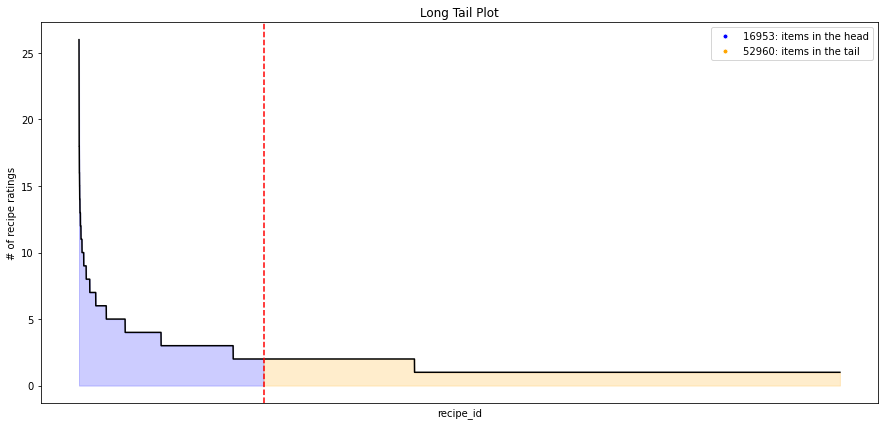

In [7]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="recipe_id", 
             interaction_type="recipe ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

## Format data for Surprise

In [8]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'recipe_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

## Train KNN Recommender

In [9]:
algo = KNNBasic(k=10)
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


## Make predictions on KNN test set

In [10]:
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['user_id', 'recipe_id', 'actual', 'cf_predictions']
test.head()

,user_id,recipe_id,actual,cf_predictions
0,3682,97386,5.0,5.000000
1,49477,46075,5.0,5.000000
2,14971,125733,5.0,5.000000
3,7224,71410,5.0,4.799491
4,44573,47707,5.0,4.808967


## Evaluate model with MSE and RMSE

In [11]:
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.2262091712038709
RMSE:  0.47561451954694456


In [12]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='user_id', columns='recipe_id', values='cf_predictions').fillna(0)

In [13]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [14]:
#get example prediction
get_users_predictions(25281, 10, cf_model)

[119108, 137308, 134847, 17434, 93976, 72223, 57514, 25575, 46395, 136101]

In [15]:
get_users_predictions(31330, 10, cf_model)

[122795, 114541, 134330, 97246, 133418, 94795, 117221, 132804, 82001, 93682]

In [42]:
get_users_predictions(49477, 10, cf_model)

[90679, 126624, 64784, 135852, 116733, 122320, 77854, 135817, 66984, 116588]

In [16]:
test = test.copy().groupby('user_id', as_index=False)['recipe_id'].agg({'actual': (lambda x: list(set(x)))})

In [17]:
test = test.set_index("user_id")

In [18]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
user_id,,
178,"[63494, 53255, 26632, 32774, 2058, 45064, 2458...","[13738, 47701, 104421, 31640, 26517, 98353, 50..."
215,"[57348, 24586, 65552, 18448, 53276, 79903, 822...","[32099, 32280, 2238, 102829, 51947, 20474, 170..."
351,"[42496, 5120, 11783, 37897, 39946, 13323, 5838...","[28715, 8284, 14957, 9719, 15546, 43175, 29948..."
531,"[55317, 12316, 83998, 16420, 71716, 55334, 635...","[69251, 59198, 63539, 46348, 36243, 15826, 764..."
617,"[28672, 27142, 8198, 16906, 30219, 5132, 18448...","[4548, 13053, 33042, 14809, 38301, 8933, 2720,..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 recipes to every user.

In [19]:
#make recommendations for all members in the test data
popularity_recs = ratings.recipe_id.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
user_id,,,
178,"[63494, 53255, 26632, 32774, 2058, 45064, 2458...","[13738, 47701, 104421, 31640, 26517, 98353, 50...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
215,"[57348, 24586, 65552, 18448, 53276, 79903, 822...","[32099, 32280, 2238, 102829, 51947, 20474, 170...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
351,"[42496, 5120, 11783, 37897, 39946, 13323, 5838...","[28715, 8284, 14957, 9719, 15546, 43175, 29948...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
531,"[55317, 12316, 83998, 16420, 71716, 55334, 635...","[69251, 59198, 63539, 46348, 36243, 15826, 764...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
617,"[28672, 27142, 8198, 16906, 30219, 5132, 18448...","[4548, 13053, 33042, 14809, 38301, 8933, 2720,...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random recipes to every user.

In [20]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = ratings.recipe_id.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
user_id,,,,
178,"[63494, 53255, 26632, 32774, 2058, 45064, 2458...","[13738, 47701, 104421, 31640, 26517, 98353, 50...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[126438, 117787, 118756, 24573, 128832, 85757,..."
215,"[57348, 24586, 65552, 18448, 53276, 79903, 822...","[32099, 32280, 2238, 102829, 51947, 20474, 170...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[79802, 129233, 43269, 76329, 13445, 48764, 13..."
351,"[42496, 5120, 11783, 37897, 39946, 13323, 5838...","[28715, 8284, 14957, 9719, 15546, 43175, 29948...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[65986, 33558, 136412, 116336, 129357, 82439, ..."
531,"[55317, 12316, 83998, 16420, 71716, 55334, 635...","[69251, 59198, 63539, 46348, 36243, 15826, 764...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[110730, 79605, 91812, 18662, 119799, 22308, 7..."
617,"[28672, 27142, 8198, 16906, 30219, 5132, 18448...","[4548, 13053, 33042, 14809, 38301, 8933, 2720,...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[14420, 21609, 7861, 101590, 57990, 126153, 62..."


# Recall

In [21]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [22]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.00018723350720441096,
 0.00022544573928403534,
 0.0002925922233883412,
 0.0003255012192196602,
 0.0003619135175367204,
 0.0003769238528142382,
 0.0004212018034803362,
 0.0004749043424246376,
 0.0005536710587549616,
 0.0005847293920752453]

In [23]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0,
 0.0,
 1.5656305513881108e-05,
 1.5656305513881108e-05,
 1.7793057650633247e-05,
 1.7793057650633247e-05,
 1.7793057650633247e-05,
 2.668518450019563e-05,
 3.144940331123718e-05,
 3.781734779799355e-05]

In [24]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.002682528581899848,
 0.005365057163799696,
 0.008047585745699545,
 0.010730114327599393,
 0.01341264290949924,
 0.01609517149139909,
 0.018777700073298938,
 0.021460228655198785,
 0.02414275723709863,
 0.02682528581899848]

# Mark Plot

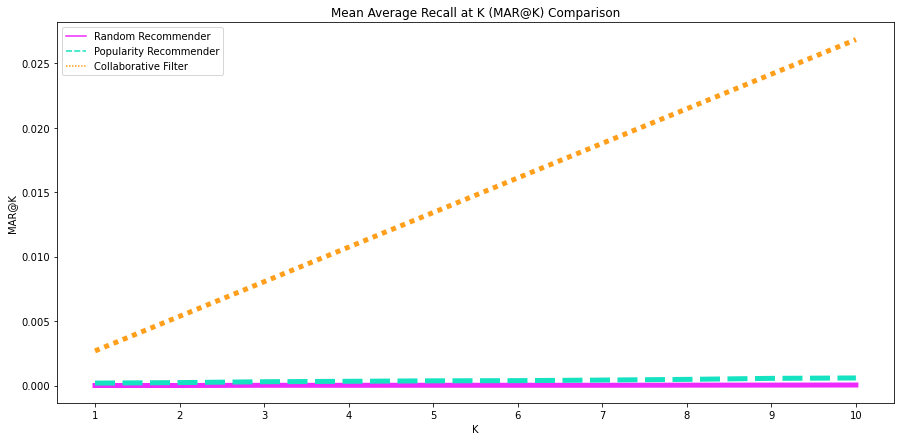

In [25]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

# Prediction Coverage

In [26]:
catalog = ratings.recipe_id.unique().tolist()
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)

# Catalog Coverage

In [27]:
# N=100 observed recommendation lists
random_cat_coverage = recmetrics.catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = recmetrics.catalog_coverage(cf_recs, catalog, 100)
print(cf_cat_coverage)

0.82


# Coverage Plot

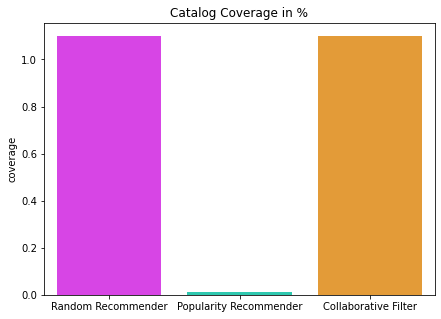

In [28]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Novelty

In [29]:
nov = ratings.recipe_id.value_counts()
pop = dict(nov)

In [30]:
random_novelty,random_mselfinfo_list = recmetrics.novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = recmetrics.novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = recmetrics.novelty(cf_recs, pop, len(users), 10)

In [31]:
print(random_novelty, pop_novelty, cf_novelty)

5.004572048358201 1.7457934751039947 4.570541470641245


# Personalization

In [43]:
example_predictions = [
    
[119108, 137308, 134847, 17434, 93976, 72223, 57514, 25575, 46395, 136101],
[122795, 114541, 134330, 97246, 133418, 94795, 117221, 132804, 82001, 93682],
[90679, 126624, 64784, 135852, 116733, 122320, 77854, 135817, 66984, 116588]
]

In [44]:
recmetrics.personalization(predicted=example_predictions)

1.0

# Intra-list Similarity

In [54]:
example_predictions = [
[137308, 134847, 17434, 93976, 57514, 25575,  136101],
[134330, 94795, 117221, 132804, 82001],
[126624, 64784, 77854, 66984, 116588]
]

In [55]:
feature_df = recipes[["'60-minutes-or-less'","'30-minutes-or-less'","'15-minutes-or-less'"]]

In [56]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.19523809523809524

# Classification Probability Plot

In [37]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["predicted", "truth"]
pred_df.head()

,predicted,truth
0,0.727281,1.0
1,0.895945,1.0
2,0.791626,1.0
3,0.834234,1.0
4,0.687331,1.0


/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


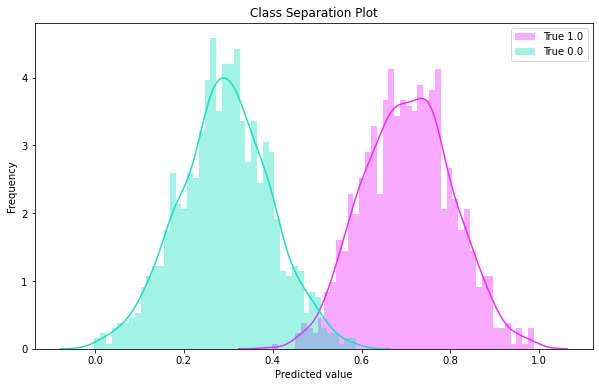

In [38]:
recmetrics.class_separation_plot(pred_df, n_bins=45, title="Class Separation Plot")

# ROC Plot

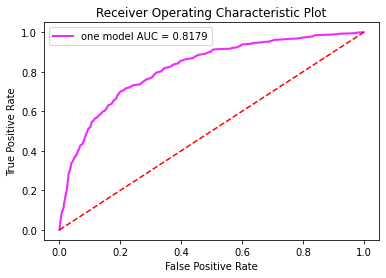

In [39]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

recmetrics.roc_plot(actual, model_probs, model_names="one model",  figsize=(10, 5))

# Precision Recall Curve

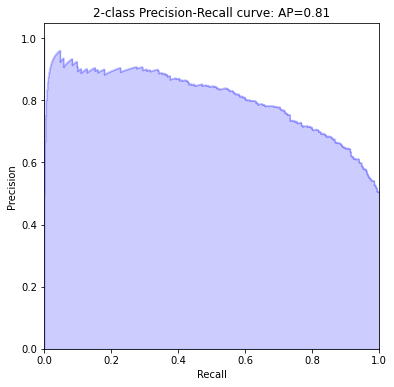

In [40]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)